In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from math import log10,sqrt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense,Flatten,Dropout
from tensorflow.keras import backend as K


In [3]:
!pip install padasip

     |████████████████████████████████| 47 kB 2.1 MB/s 


In [25]:
!pip uninstall matplotlib
!pip install matplotlib==3.1.3

Found existing installation: matplotlib 3.5.1
Uninstalling matplotlib-3.5.1:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.1-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.1.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)? y
  Successfully uninstalled matplotlib-3.5.1
     |████████████████████████████████| 13.1 MB 4.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
wfdb 3.4.1 requires m

In [4]:
!pip install wfdb

     |████████████████████████████████| 137 kB 4.1 MB/s 
     |████████████████████████████████| 11.2 MB 32.2 MB/s 
     |████████████████████████████████| 895 kB 47.9 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from os import listdir
import wfdb
import os
from skimage.restoration import denoise_wavelet
import padasip as pa
from scipy.ndimage import gaussian_filter1d
from scipy import signal,stats
import cv2
import scipy
from sklearn.metrics import mean_squared_error

In [6]:
data_path='/content/drive/MyDrive/research1/mit-bih-arrhythmia-database-1.0.0/'


In [7]:
pts=['100','101','102','103','104','105','106','107',
     '108','109','111','112','113','114','115','116',
     '117','118','119','121','122','123','124','200',
     '201','202','203','205','207','208','209','210',
     '212','213','214','215','217','219','220','221',
     '222','223','228','230','231','232','233','234']

In [8]:
df=pd.DataFrame()

for pt in pts:
    file = data_path+pt
    annotation = wfdb.rdann(file,'atr')
    sym=annotation.symbol
    
    values,counts = np.unique(sym,return_counts=True)
    df_sub=pd.DataFrame({'sym':values,'val':counts,'pt':[pt]*len(counts)})
    df = pd.concat([df,df_sub],axis=0)
print(df)


   sym   val   pt
0    +     1  100
1    A    33  100
2    N  2239  100
3    V     1  100
0    +     1  101
..  ..   ...  ...
0    +     3  234
1    J    50  234
2    N  2700  234
3    V     3  234
4    ~     8  234

[283 rows x 3 columns]


In [9]:
df.groupby('sym').val.sum().sort_values(ascending=False)

sym
N    75052
L     8075
R     7259
V     7130
/     7028
A     2546
+     1291
f      982
F      803
~      616
!      472
"      437
j      229
x      193
a      150
|      132
E      106
J       83
Q       33
e       16
[        6
]        6
S        2
Name: val, dtype: int64

In [10]:
#list of nonbeat and abnormal
nonbeat=['[','!',']','x','(',')','p','t','u','`','\'','^','|','~','+','s','T','D',
        '=','"','@','Q','?']
abnormal = ['L','R','V','/','A','f','F','j','a','E','J','e','S']

normal=['N']

In [11]:
df['cat']=-1
df.loc[df.sym == 'N','cat'] = 0
df.loc[df.sym.isin(abnormal),'cat'] = 1
df

,sym,val,pt,cat
0,+,1,100,-1
1,A,33,100,1
2,N,2239,100,0
3,V,1,100,1
0,+,1,101,-1
...,...,...,...,...
0,+,3,234,-1
1,J,50,234,1
2,N,2700,234,0
3,V,3,234,1


In [12]:
df.groupby('cat').val.sum()

cat
-1     3186
 0    75052
 1    34409
Name: val, dtype: int64

In [13]:
def load_ecg(file):
    record=wfdb.rdrecord(file)
    annotation=wfdb.rdann(file,'atr')
    p_signal = record.p_signal
    assert record.fs == 360,'sample freq is not 360'
    
    atr_sym = annotation.symbol
    atr_sample = annotation.sample
    return p_signal,atr_sym,atr_sample

In [14]:
file = data_path + pts[0]

In [15]:
p_signal,atr_sym,atr_sample = load_ecg(file)

In [16]:
values,counts = np.unique(sym,return_counts=True)
for v,c in zip(values,counts):
    print(v,c)

+ 3
J 50
N 2700
V 3
~ 8


In [17]:
#get normal beat index 
n_index = [l for m,l in zip(atr_sym,atr_sample) if m in normal][:10]
n_index

[77, 370, 662, 946, 1231, 1515, 1809, 2402, 2706, 2998]

In [18]:
# get abnormal beat index
ab_index = [b for a,b in zip(atr_sym,atr_sample) if a in abnormal][:10]
ab_index

[2044, 66792, 74986, 99579, 128085, 170719, 279576, 305709, 307745, 312825]

In [19]:
x=np.arange(len(p_signal))

64792
81792


AttributeError: ignored

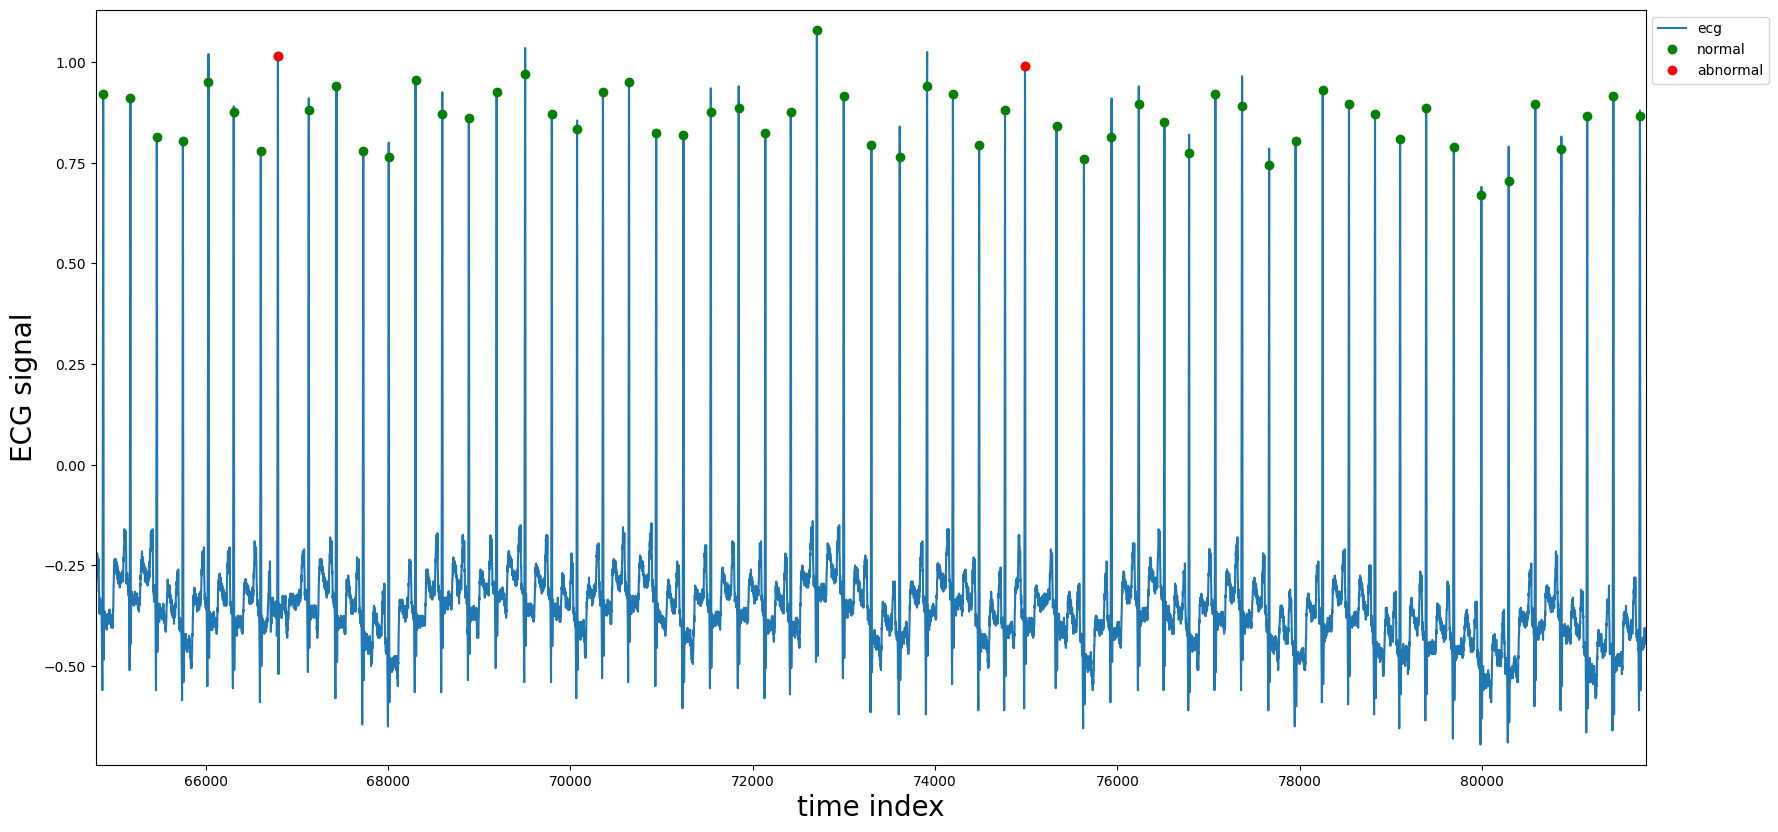

In [50]:
left = ab_index[1]-2000
right = ab_index[1]+15000

print(left)
print(right)
plt.figure(figsize=(20,10),dpi=100)
plt.plot(x[left:right],p_signal[left:right,0],'-',label='ecg')
plt.plot(x[atr_sample],p_signal[atr_sample,0],'go',label='normal')
plt.plot(x[ab_index],p_signal[ab_index,0],'ro',label='abnormal')

plt.xlim(left,right)
plt.ylim(p_signal[left:right].min()-0.05,p_signal[left:right,0].max()+0.05)
plt.xlabel('time index',size=20)
plt.ylabel('ECG signal',size=20)
plt.legend(bbox_to_anchor = (1,1),loc='upper left')
plt.pyplot.legend(list, prop={'size': 50})
plt.show()

1918
4078


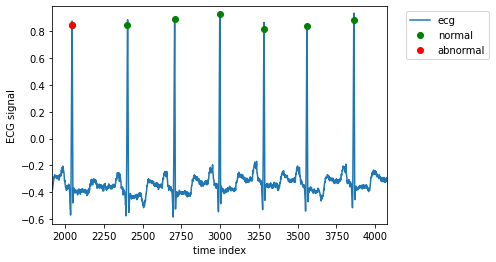

In [ ]:
left = n_index[9]-1080
right =n_index[9]+1080

print(left)
print(right)

plt.plot(x[left:right],p_signal[left:right,0],'-',label='ecg')
plt.plot(x[atr_sample],p_signal[atr_sample,0],'go',label='normal')
plt.plot(x[ab_index],p_signal[ab_index,0],'ro',label='abnormal')

plt.xlim(left,right)
plt.ylim(p_signal[left:right].min()-0.05,p_signal[left:right,0].max()+0.05)
plt.xlabel('time index')
plt.ylabel('ECG signal')
plt.legend(bbox_to_anchor = (1.04,1),loc='upper left')
plt.show()

In [20]:
def make_dataset(pts, num_sec, fs, abnormal):
    # function for making dataset ignoring non-beats
    # input:
    # pts - list of patients
    # num_sec = number of seconds to include before and after the beat
    # fs = frequency
    # output: 
    #   X_all = signal (nbeats , num_sec * fs columns)
    #   Y_all = binary is abnormal (nbeats, 1)
    #   sym_all = beat annotation symbol (nbeats,1)
    
    # initialize numpy arrays
    num_cols = 2*num_sec * fs
    X_all = np.zeros((1,num_cols))
    Y_all = np.zeros((1,1))
    sym_all = []
    
    # list to keep track of number of beats across patients
    max_rows = []
    
    for pt in pts:
        file = data_path + pt
        
        p_signal, atr_sym, atr_sample = load_ecg(file)
        
        # grab the first signal
        p_signal = p_signal[:,0]
        
        # make df to exclude the nonbeats
        df_ann = pd.DataFrame({'atr_sym':atr_sym,
                              'atr_sample':atr_sample})
        df_ann = df_ann.loc[df_ann.atr_sym.isin(abnormal + ['N'])]
        
        X,Y,sym = build_XY(p_signal,df_ann, num_cols, abnormal)
        sym_all = sym_all+sym
        max_rows.append(X.shape[0])
        X_all = np.append(X_all,X,axis = 0)
        Y_all = np.append(Y_all,Y,axis = 0)
    # drop the first zero row
    X_all = X_all[1:,:]
    Y_all = Y_all[1:,:]
    
    # check sizes make sense
    assert np.sum(max_rows) == X_all.shape[0], 'number of X, max_rows rows messed up'
    assert Y_all.shape[0] == X_all.shape[0], 'number of X, Y rows messed up'
    assert Y_all.shape[0] == len(sym_all), 'number of Y, sym rows messed up'
    return X_all, Y_all, sym_all
def build_XY(p_signal, df_ann, num_cols, abnormal):
    # this function builds the X,Y matrices for each beat
    # it also returns the original symbols for Y
    
    num_rows = len(df_ann)
    X = np.zeros((num_rows, num_cols))
    Y = np.zeros((num_rows,1))
    sym = []
    
    # keep track of rows
    max_row = 0
    for atr_sample, atr_sym in zip(df_ann.atr_sample.values,df_ann.atr_sym.values):
        left = max([0,(atr_sample - num_sec*fs) ])
        right = min([len(p_signal),(atr_sample + num_sec*fs) ])
        x = p_signal[left: right]
        if len(x) == num_cols:
            X[max_row,:] = x
            Y[max_row,:] = int(atr_sym in abnormal)
            sym.append(atr_sym)
            max_row += 1
    X = X[:max_row,:]
    Y = Y[:max_row,:]
    return X,Y,sym

In [21]:
num_sec = 3
fs = 360
X_all, Y_all, sym_all = make_dataset(pts, num_sec, fs,abnormal)
X_all
p=X_all[2,:]




In [22]:
import numpy as np 
import pywt
from skimage.restoration import denoise_wavelet
import matplotlib.pyplot as plt

In [23]:
sigma=0.25
x_noise=p+sigma*np.random.randn(p.size)


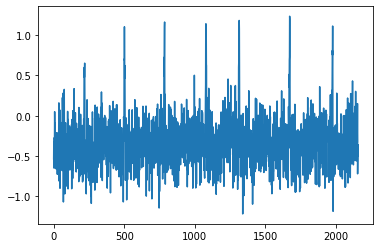

In [26]:
plt.plot(x_noise)

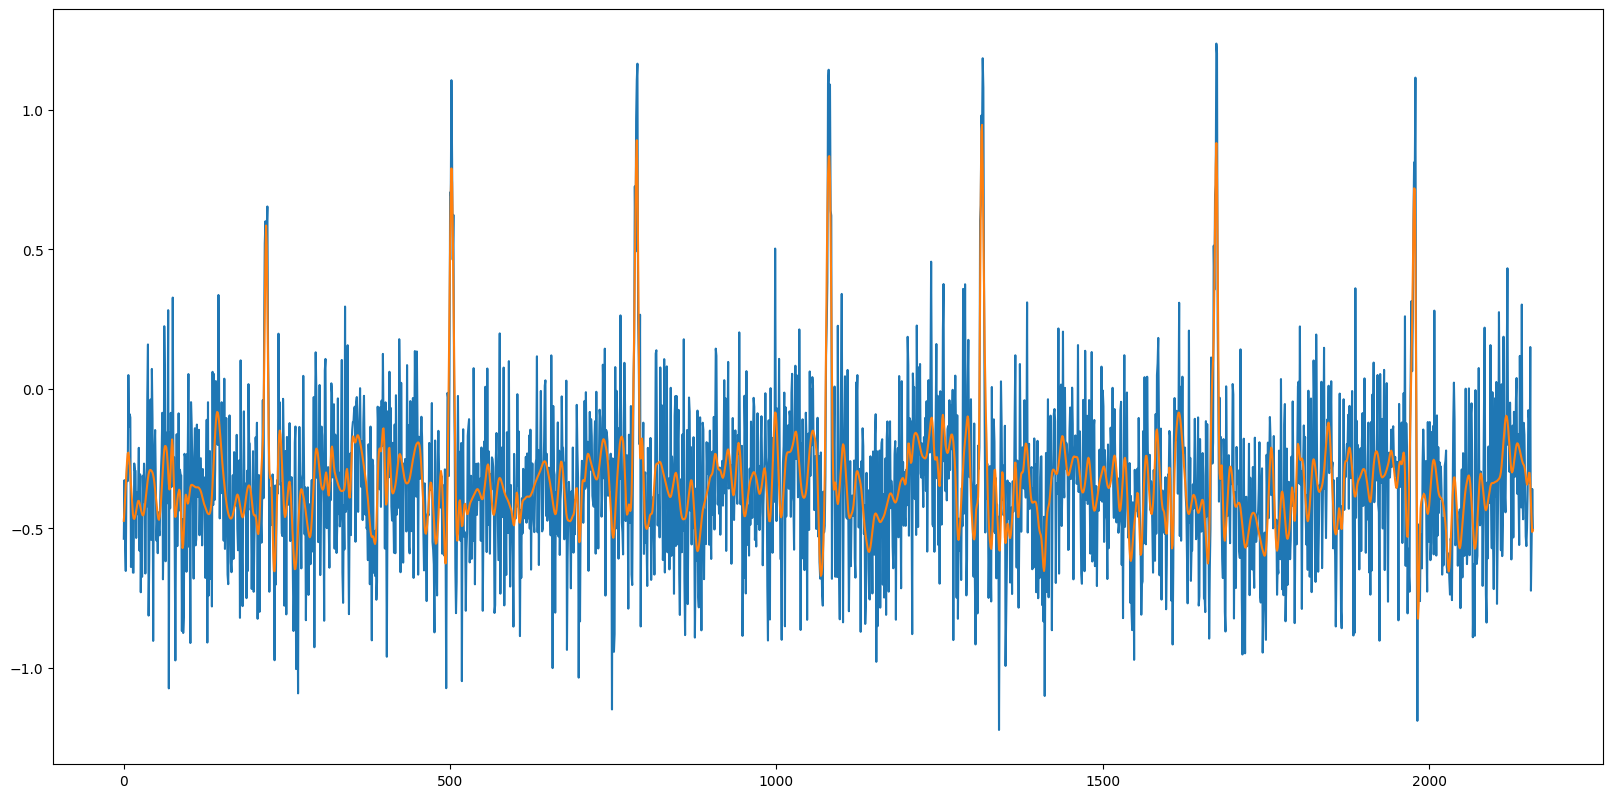

In [27]:
#wavelet Denoising 
x_denoise = denoise_wavelet( x_noise,method='BayesShrink',mode='soft',wavelet_levels=3,wavelet='sym8')
plt.figure(figsize=(20,10),dpi=100)
plt.plot(x_noise)
plt.plot(x_denoise,color="#ff7f0e")

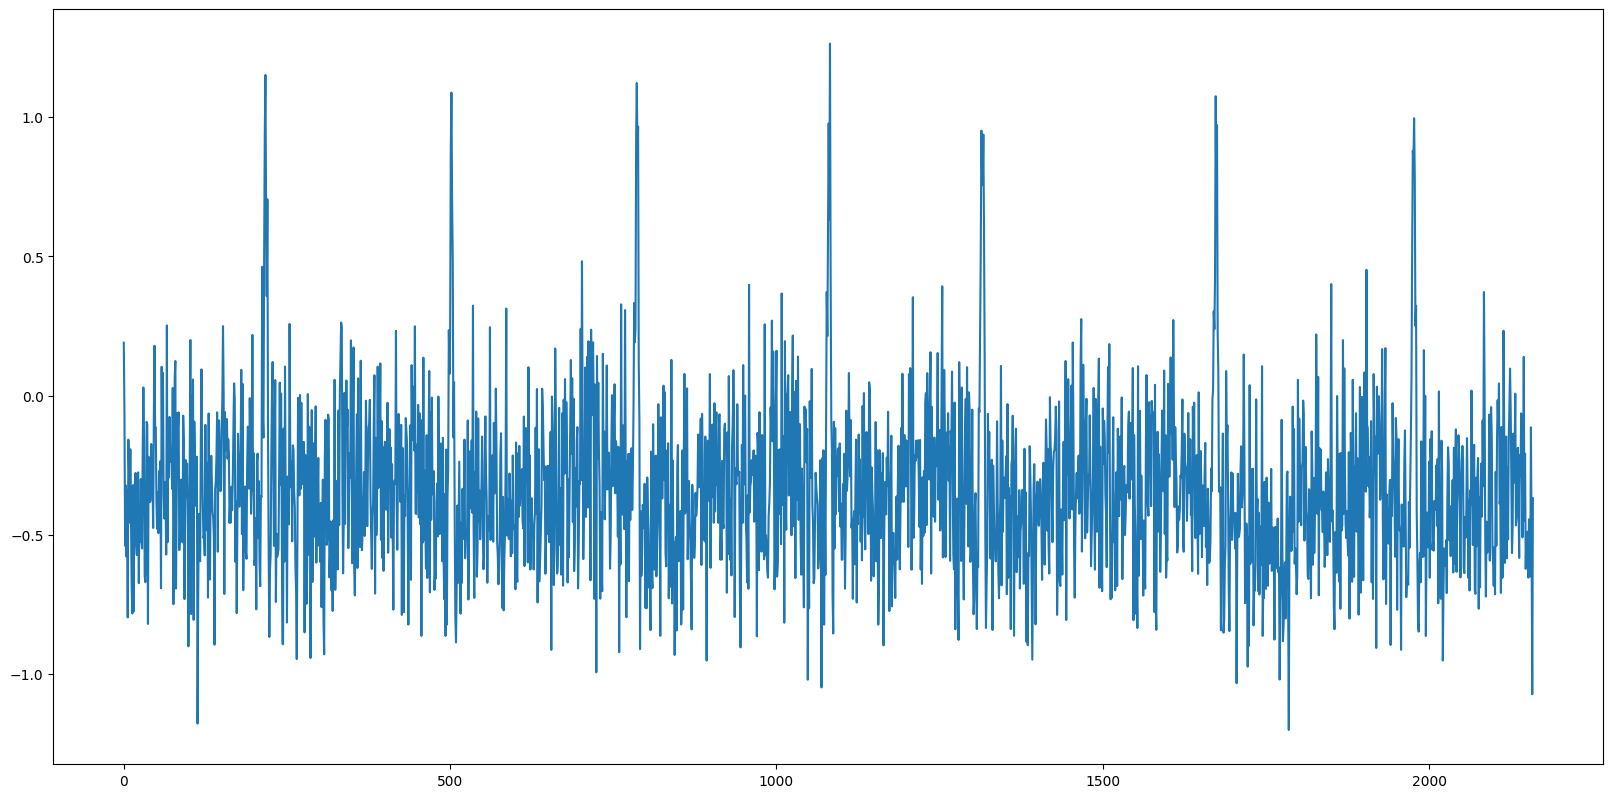

In [ ]:
plt.figure(figsize=(20,10),dpi=100)
plt.plot(x_noise)

array([-0.37854   , -0.38198727, -0.3855871 , ..., -0.4271513 ,
       -0.41613794, -0.4166948 ])

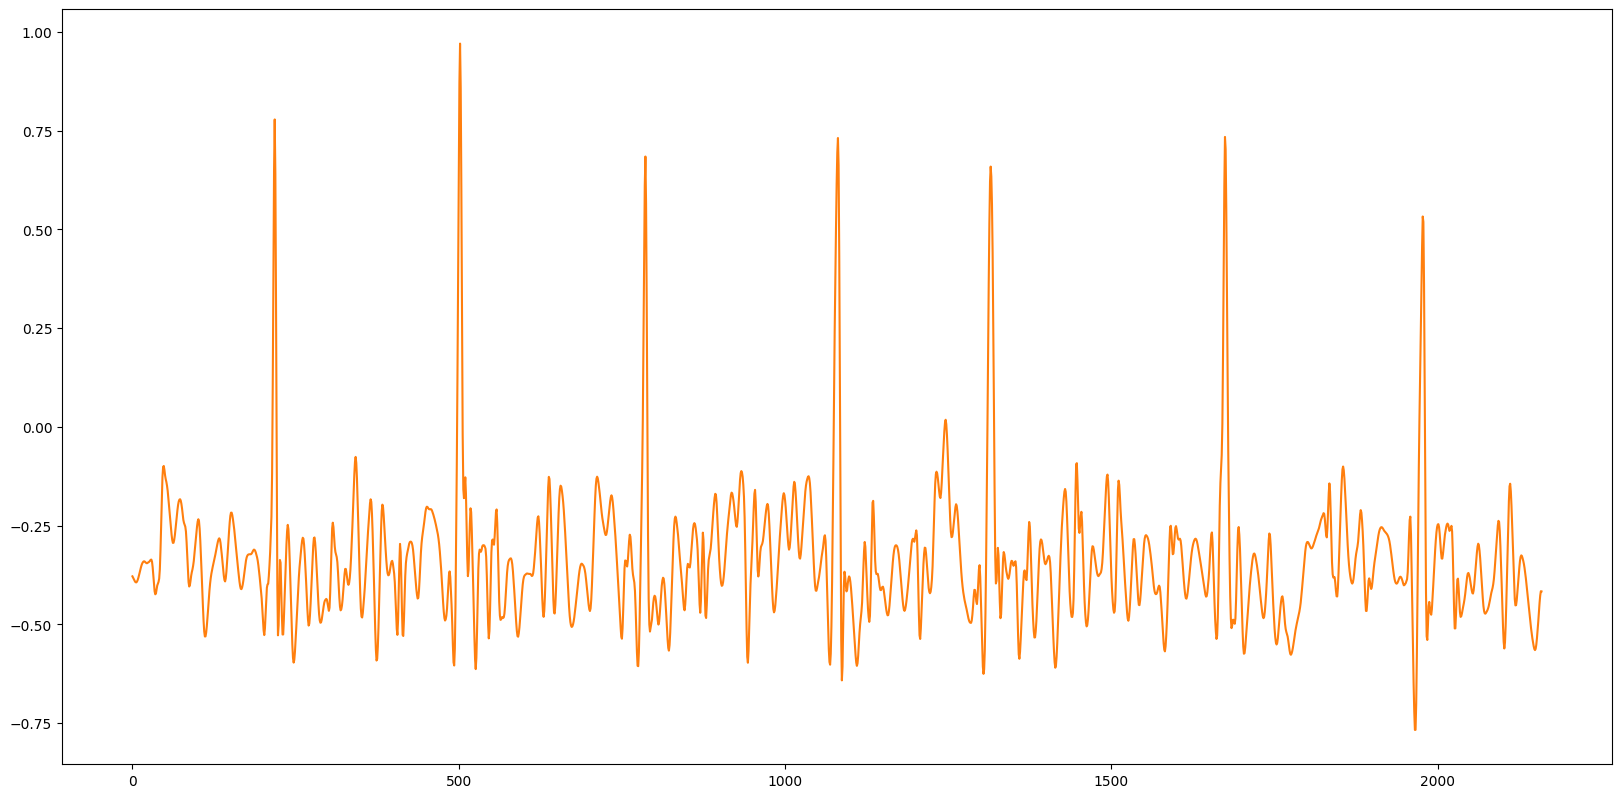

In [ ]:
plt.figure(figsize=(20,10),dpi=100)
plt.plot(x_denoise,color="#ff7f0e")
x_denoise

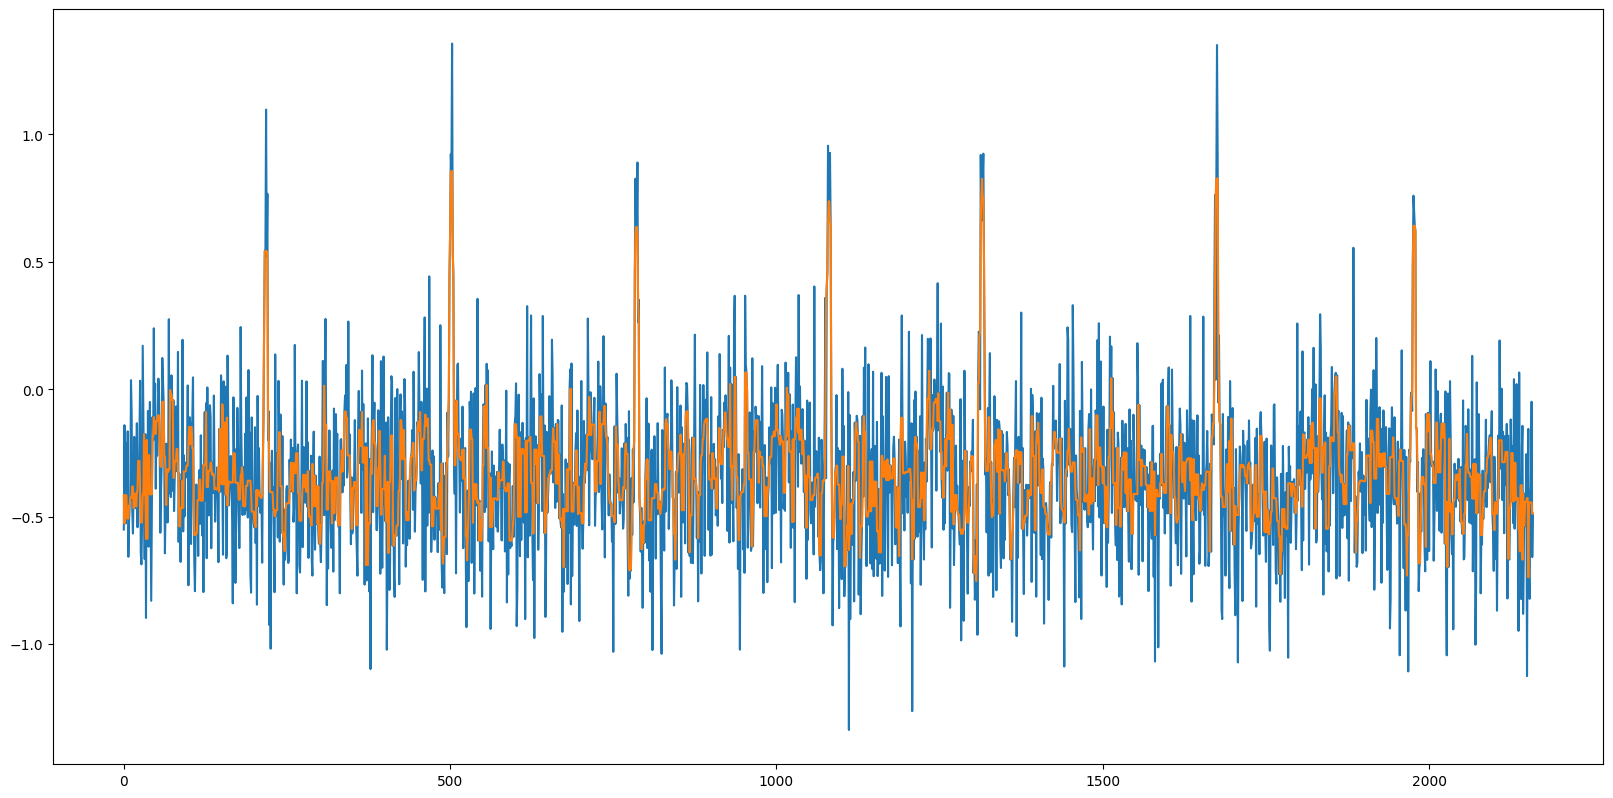

In [ ]:
#implementing median filter using scipy
plt.figure(figsize=(20,10),dpi=100)
med=scipy.ndimage.median_filter(x_noise,size=5)
plt.plot(x_noise)
plt.plot(med,color="#ff7f0e")

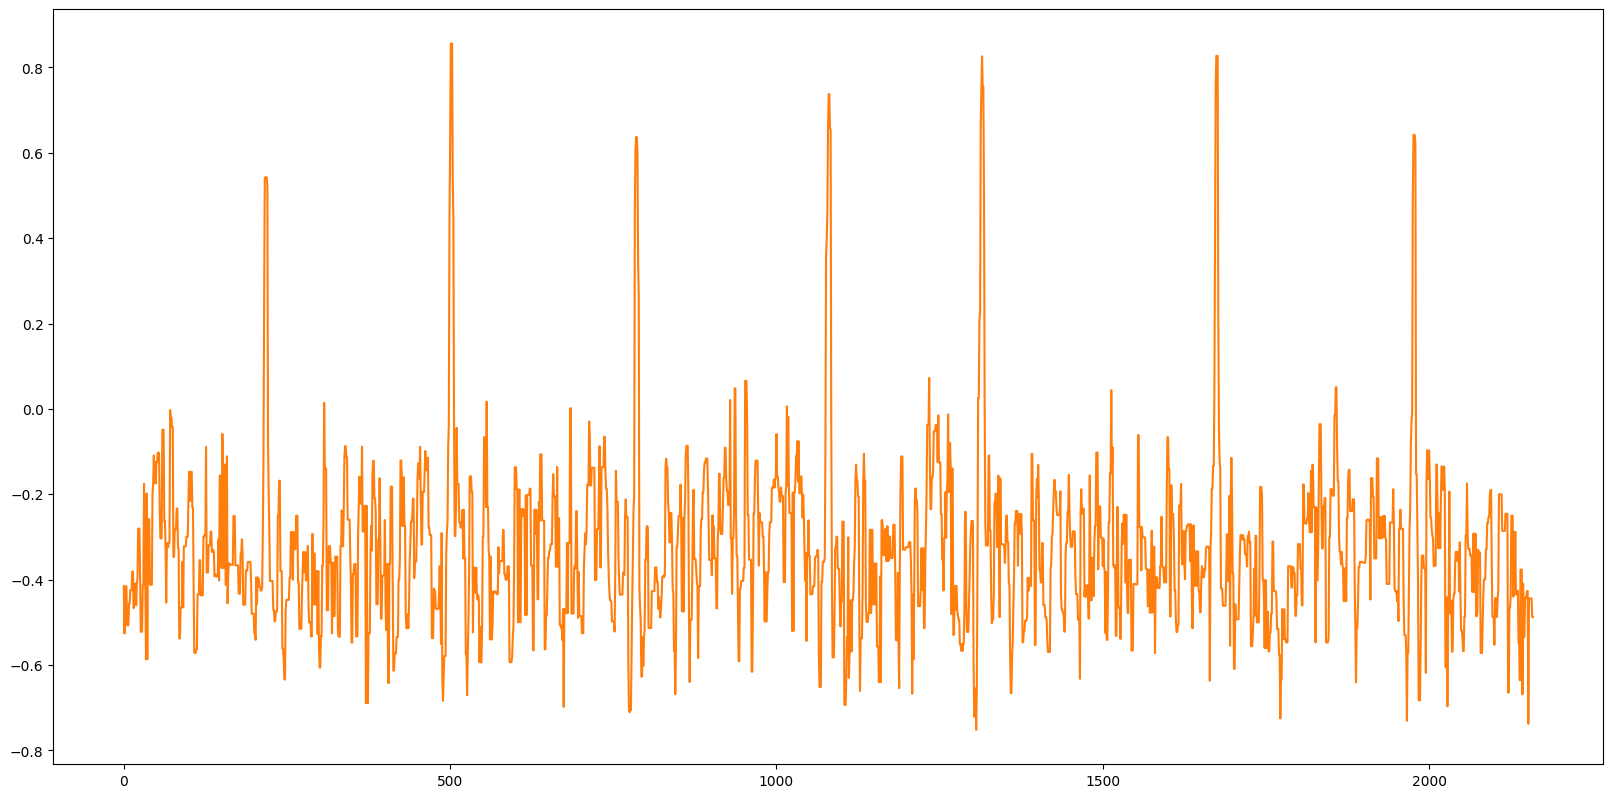

In [ ]:
plt.figure(figsize=(20,10),dpi=100)
plt.plot(med,color="#ff7f0e")

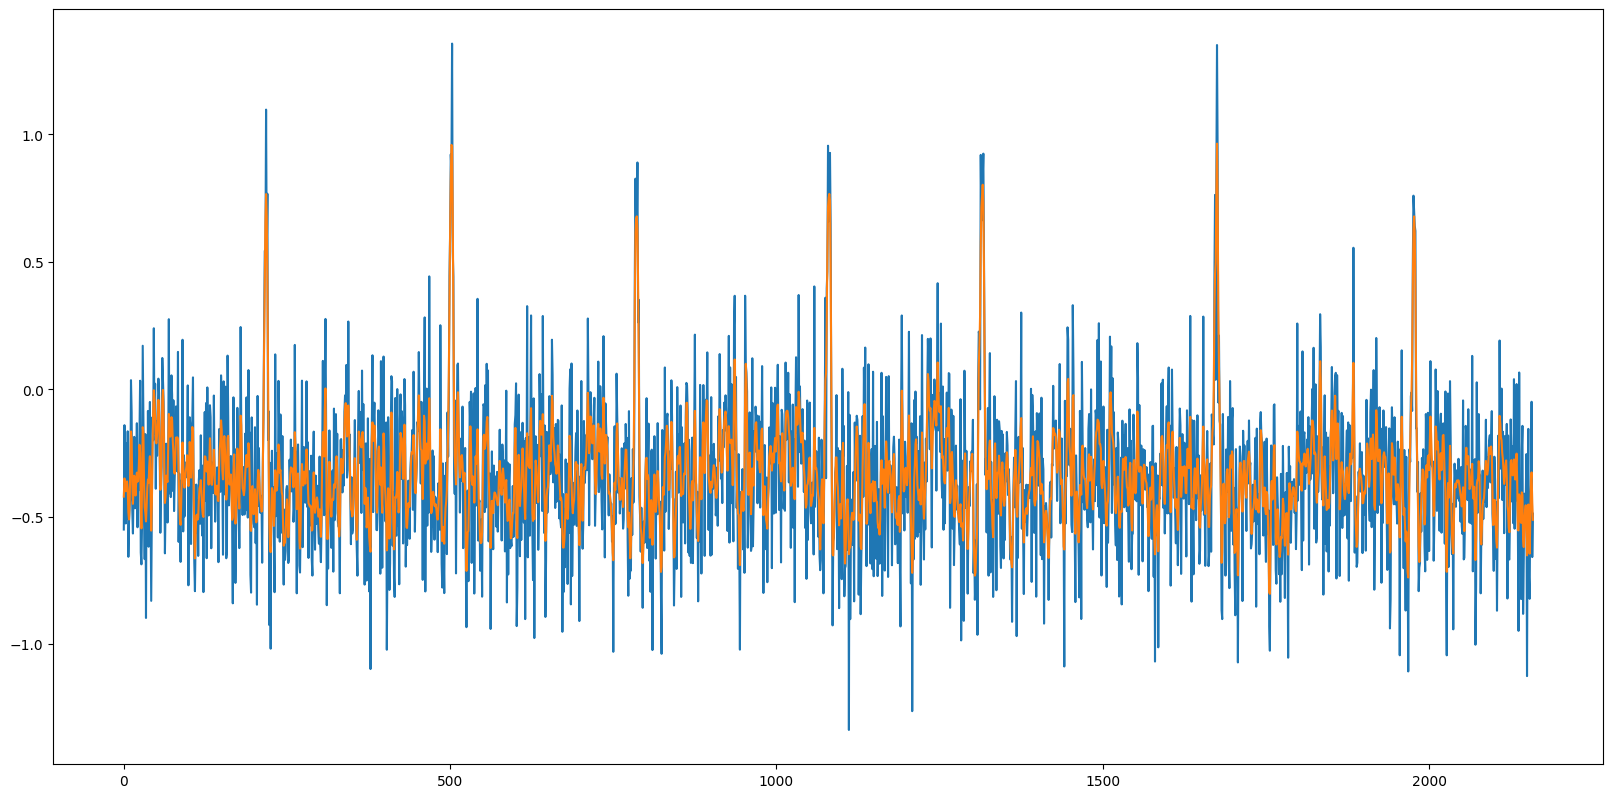

In [ ]:
#implementation of gussian filter 1d
gua=gaussian_filter1d(x_noise,1)
plt.figure(figsize=(20,10),dpi=100)
plt.plot(x_noise)
plt.plot(gua,color="#ff7f0e")

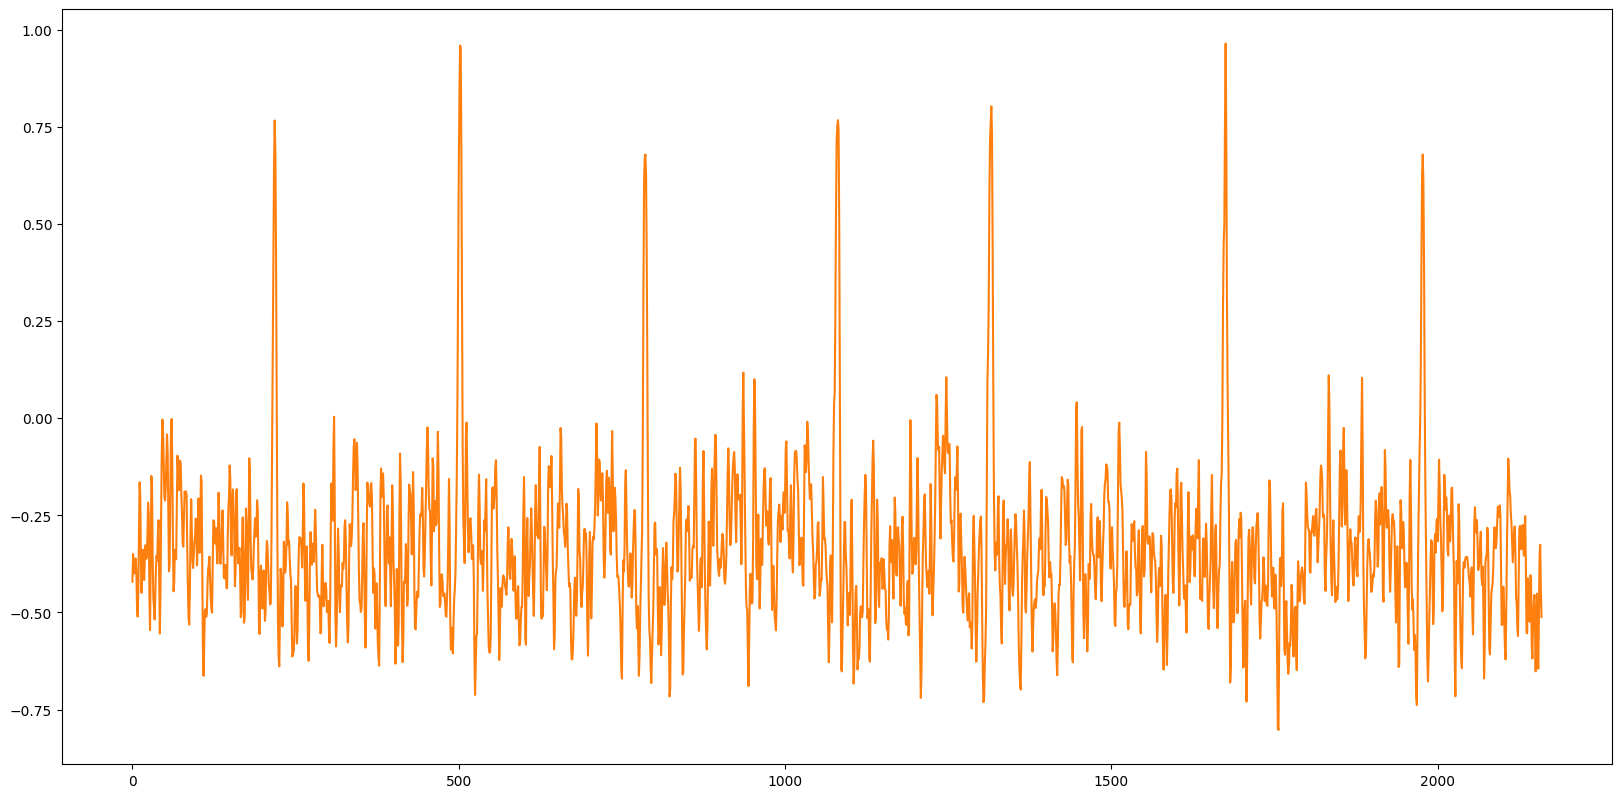

In [ ]:
plt.figure(figsize=(20,10),dpi=100)
plt.plot(gua,color="#ff7f0e")

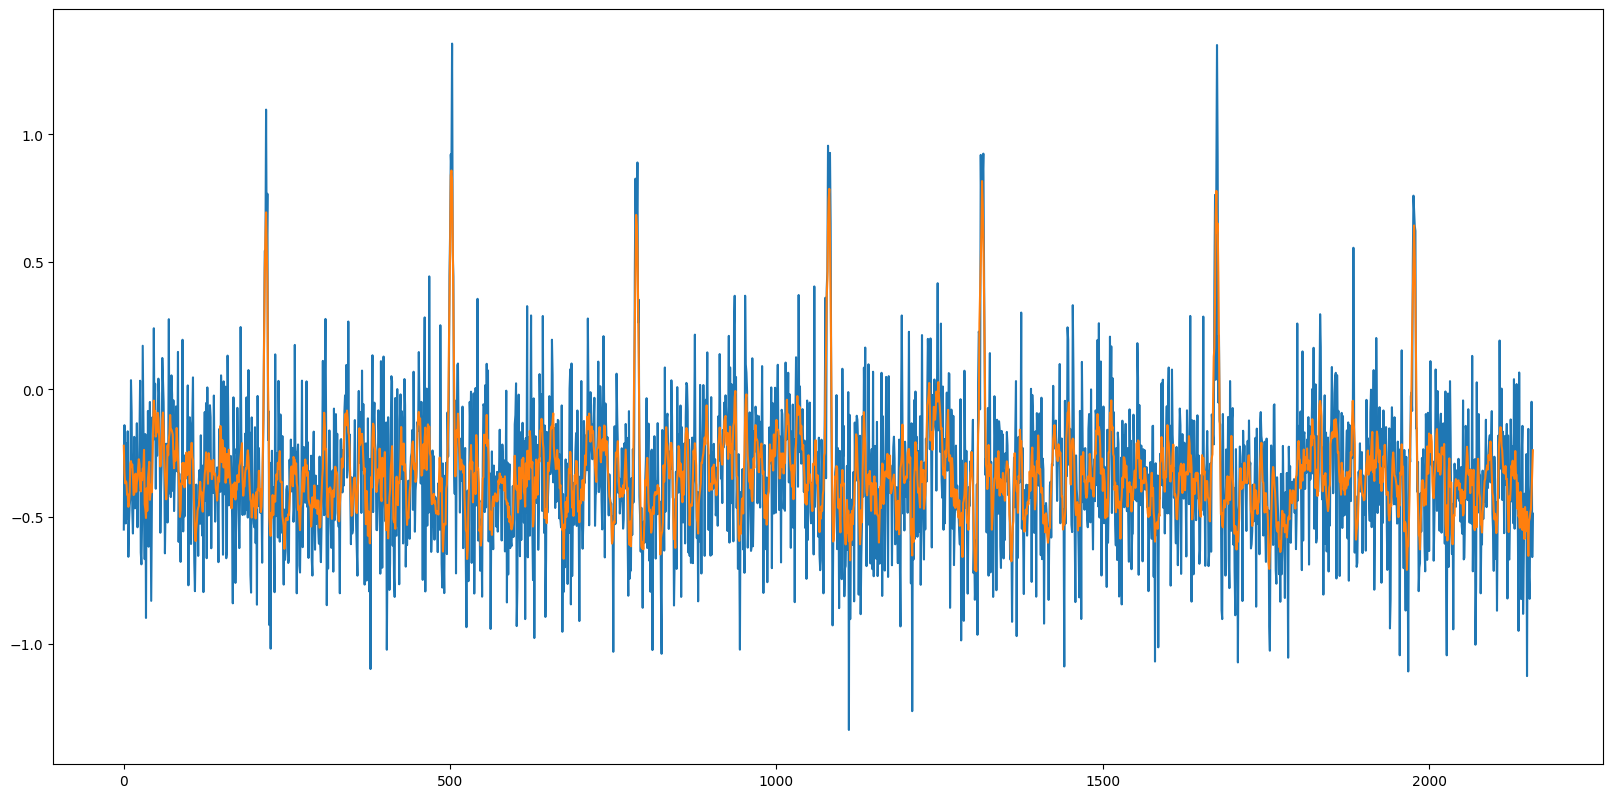

In [ ]:
#moving average 
filter_length = 5
tair_moving_average = np.convolve(x_noise,np.ones((filter_length)),mode='same')
tair_moving_average/=filter_length
plt.figure(figsize=(20,10),dpi=100)
plt.plot(x_noise)
plt.plot(tair_moving_average,color="#ff7f0e")

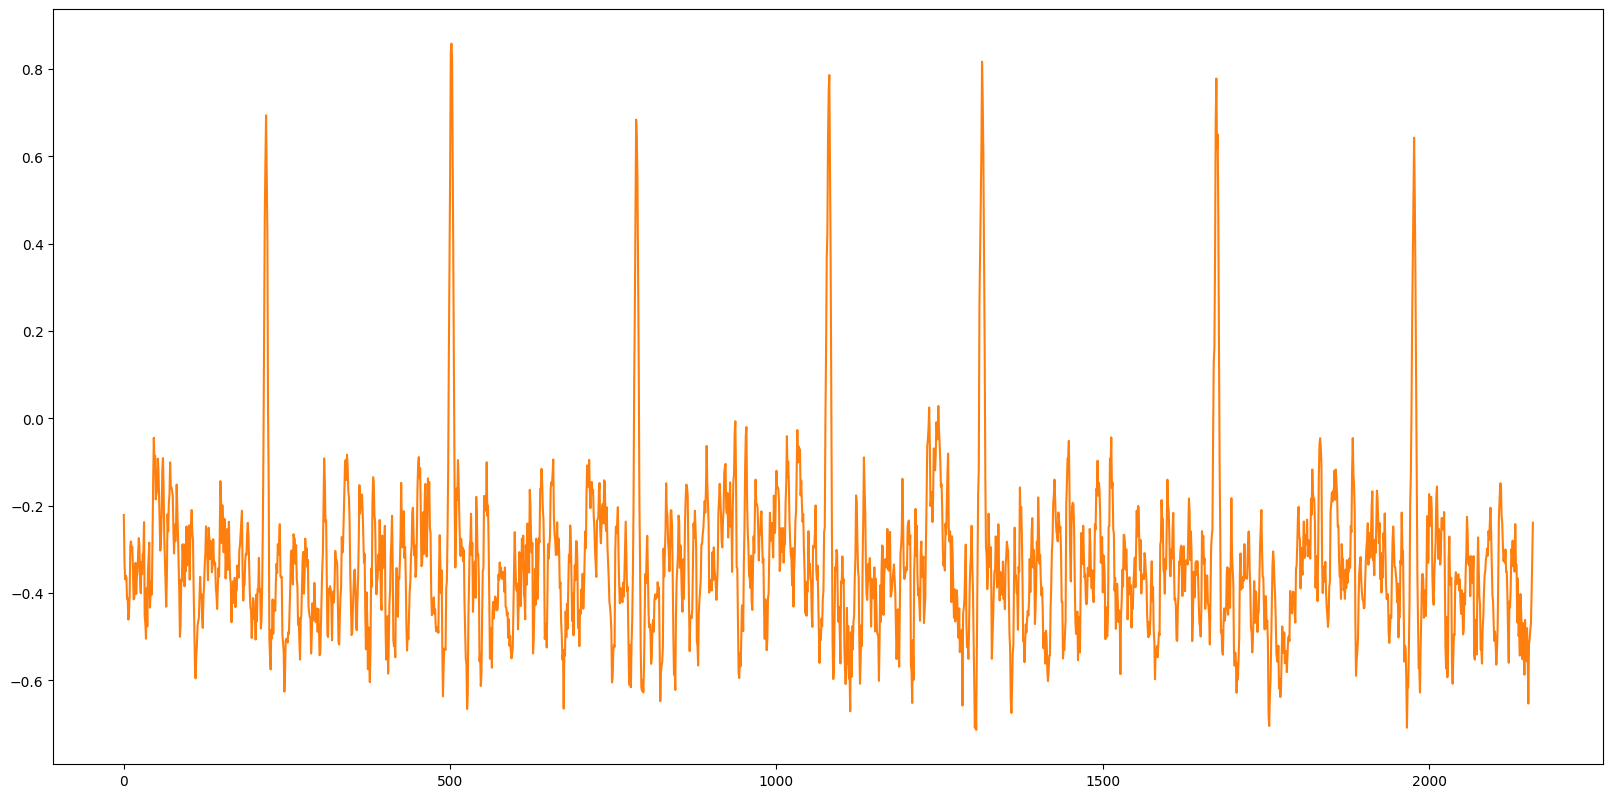

In [ ]:
plt.figure(figsize=(20,10),dpi=100)
plt.plot(tair_moving_average,color="#ff7f0e")

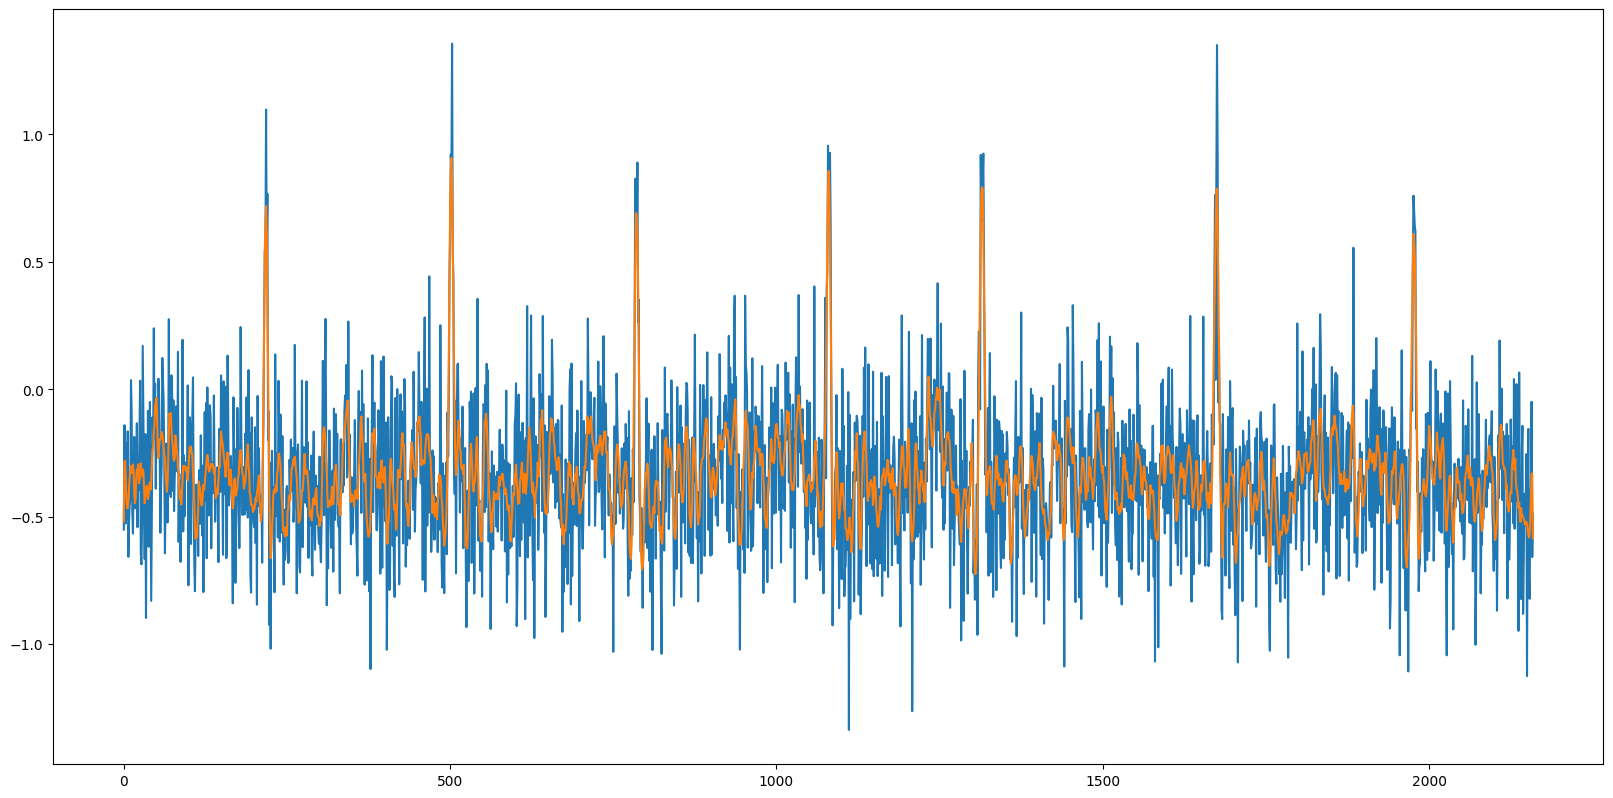

In [ ]:
#savitzky-golay filter 
sg_filtered = signal.savgol_filter(  x_noise,25,7)
plt.figure(figsize=(20,10),dpi=100)

plt.plot(x_noise)
plt.plot(sg_filtered,color="#ff7f0e")

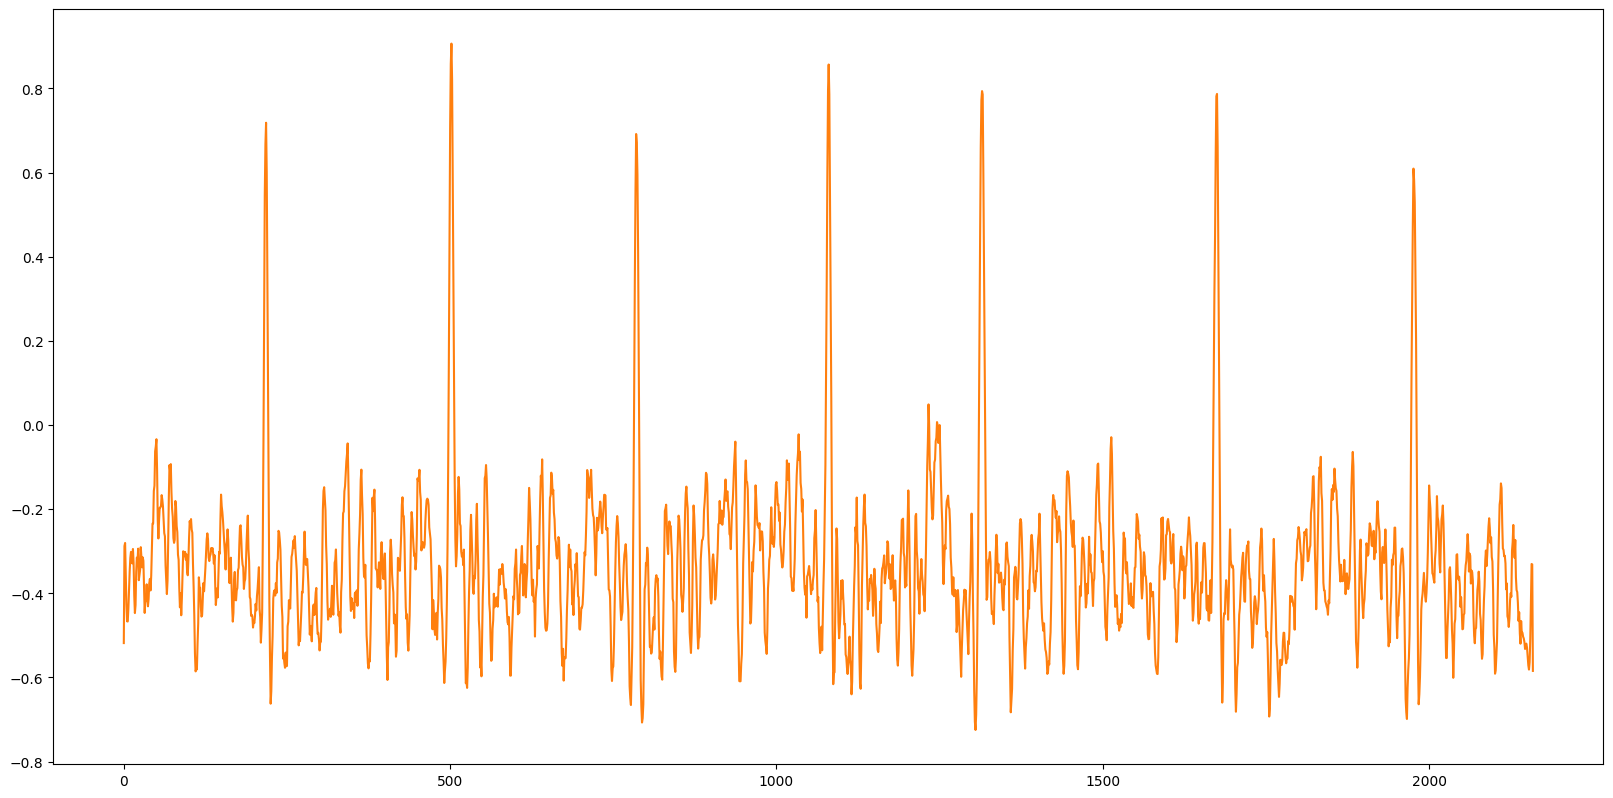

In [ ]:
plt.figure(figsize=(20,10),dpi=100)
plt.plot(sg_filtered,color="#ff7f0e")

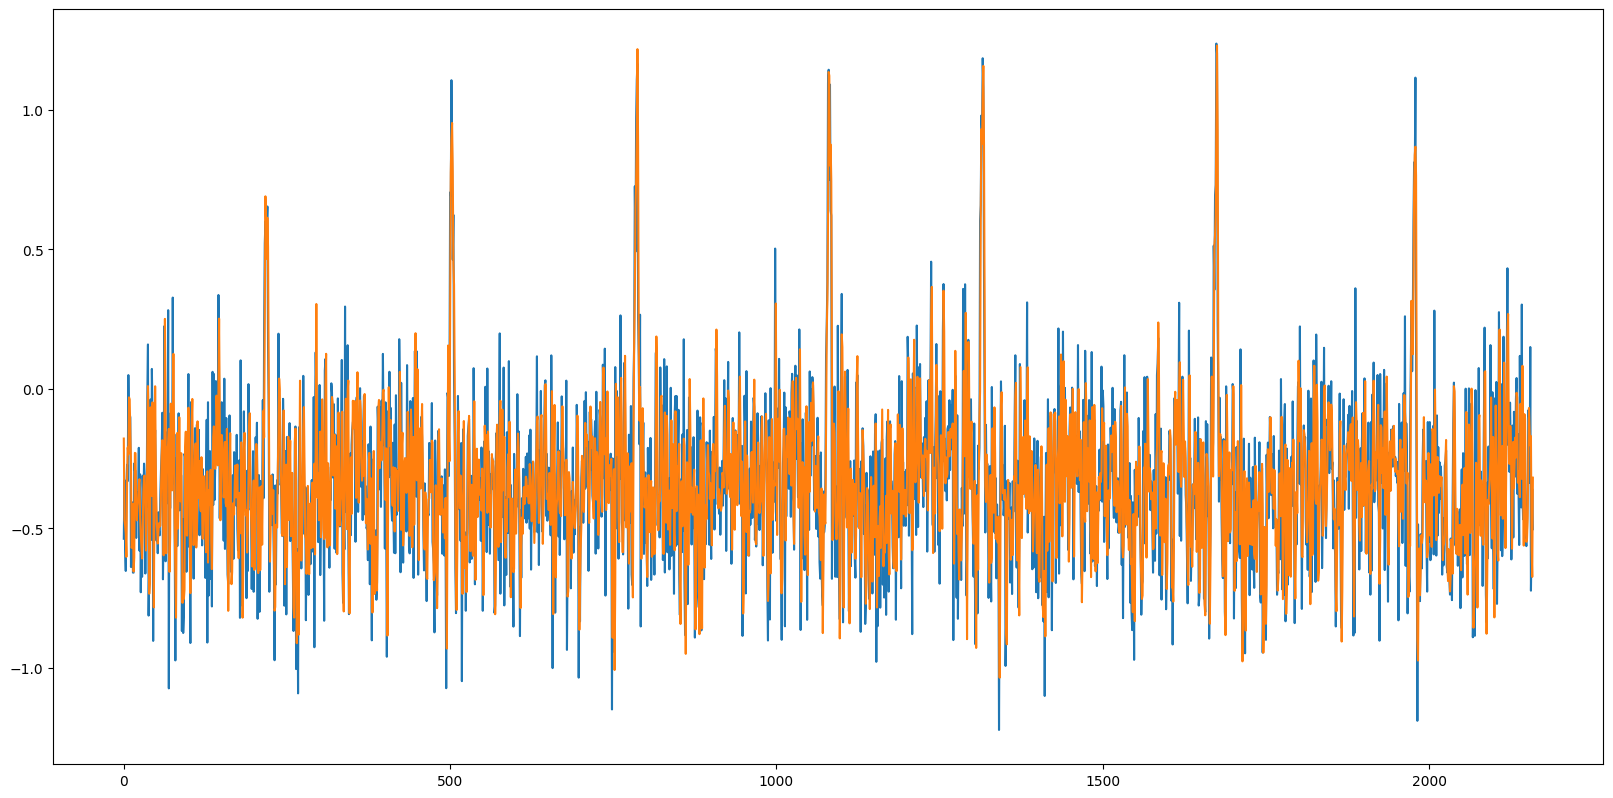

In [31]:
#low pass butterworth filter 
bwf=signal.butter( 3,120,'low',fs=360,output='sos')
filt=signal.sosfilt(bwf,x_noise)
plt.figure(figsize=(20,10),dpi=100)

plt.plot(x_noise)
plt.plot(filt)

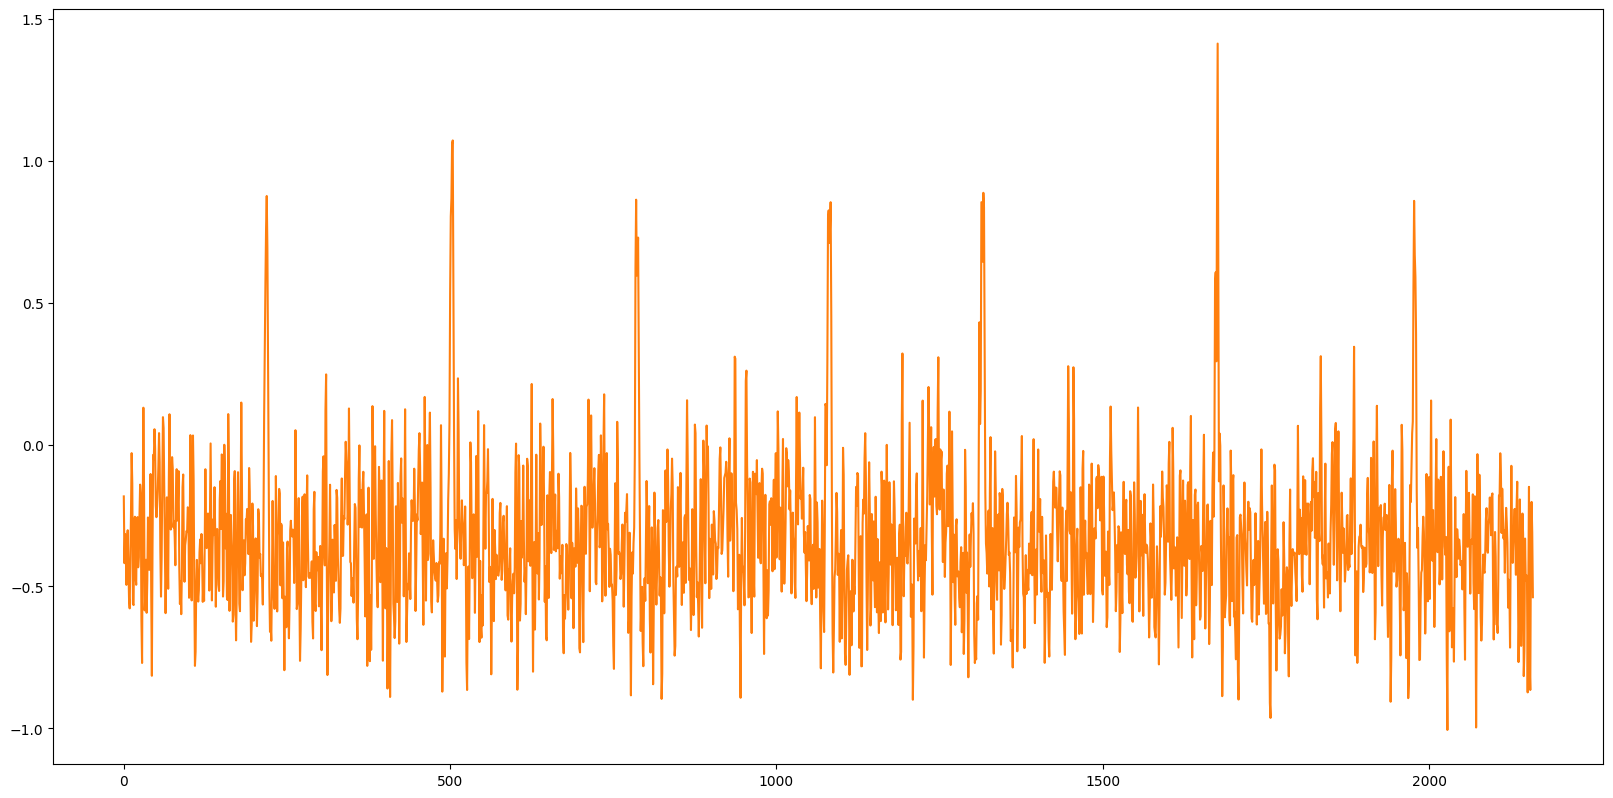

In [ ]:
plt.figure(figsize=(20,10),dpi=100)
plt.plot(filt,color="#ff7f0e")